# CS375 - Assignment 2
#### In this notebook I trained and tested the pooled shallow bottleneck autoencoder model.

## Training and testing

In [34]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

In [35]:
from dldata.metrics.utils import compute_metric_base

### Getting data from the database
Let's connect to the database and pull the data training and test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [36]:
# connect to database
dbname = 'assignment2'
collname = 'pooled_bottleneck'
exp_id = '1st_experiment'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))

[u'1st_experiment']


In [37]:
#For debugging only! Deletes training data.
#conn[dbname].drop_collection('pooled_bottleneck.files')
#conn[dbname].drop_collection('pooled_bottleneck_sparse.files')

This shows us all stored experiments. In case you want to delete a particular experiment because you are running out of disk space, you can uncomment and use the following line. You could also just drop the entire collection or even the entire database if you want to get of all of them, but I recommend removing them one by one.

### Plotting the training curve
Now we are interested to see the training curve for exp_id='experiment_1' for example. So the first thing we have to do is to pull the training loss from the database and then we can plot it. I implemented a function that will pull and return the training loss per iteration for you.

Your first task is to take the training loss and plot 1.) the training loss and 2.) a smoothed version of the training loss which you can effectively get by convolving the loss with a vector of ones kernel. You might find the function 'scipy.signal.convolve' useful to solve this task. Experiment with various kernel lengths and describe what you see.

(1000,)


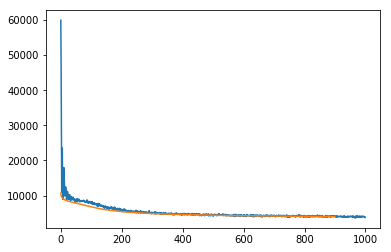

In [38]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

loss = get_losses(coll, exp_id)
print(loss.shape)

# Plot the training loss
plt.plot(loss)

# Plot a smoothed version 
plt.plot(smooth_signal(loss,100))


The model learned very quickly, with barely any progress after its initial improvement.

### Plotting the validation results
After our train_imagenet function has evaluated the Image Net validation set for the time we can have a look at the validation results of for example exp_id='experiment_1'. Again, you need to pull the validation data from the database first. The validation data consists of the top1 and top5 accuracy that you have implemented previously. 

We have provided a function that pulls the necessary data from the database. Your task is to plot the validation curve of the top1 and top5 accuracy. Label the graphs respectively and describe what you see.

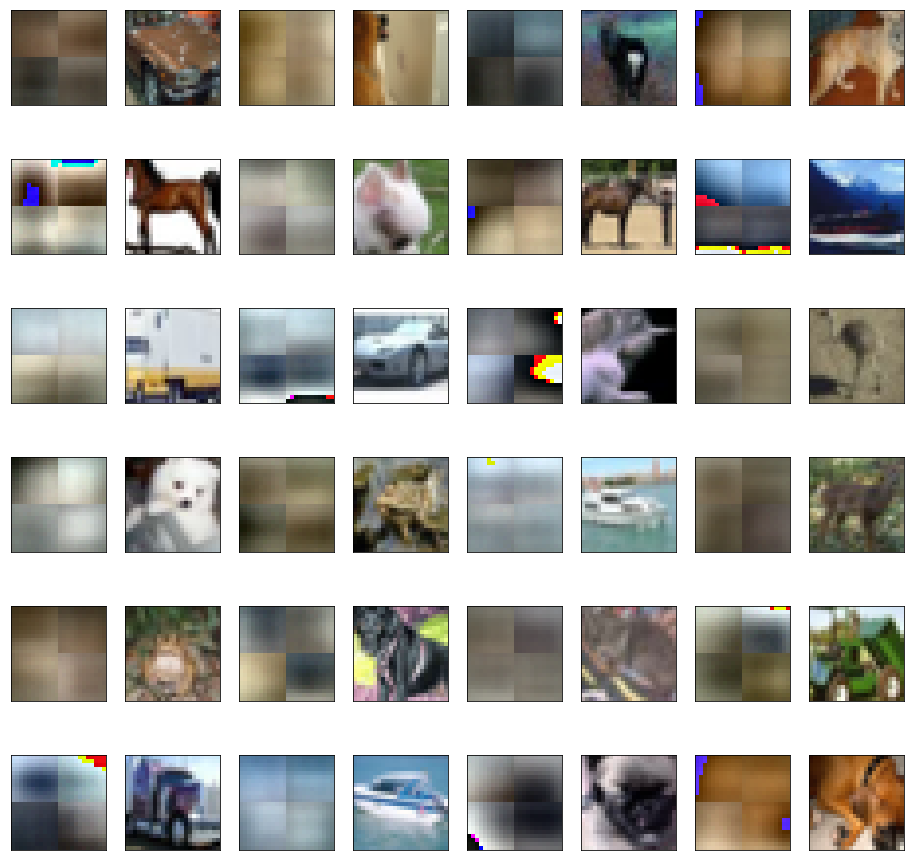

In [39]:
def get_validation_images(coll,exp_id):
    """
    Gets the validation images from the database
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    pred = np.array([val_steps[i]['validation_results']['valid0']['pred'] 
            for i in range(val_steps.count())])
    gt = np.array([val_steps[i]['validation_results']['valid0']['gt'] 
            for i in range(val_steps.count())])
    return {'gt': gt, 'pred': pred}

def plot_validation_images(coll, exp_id, n_images = 24):
    '''
    Plots n_images images in a grid. The ground truth image is on the left 
    and the prediction is on the right.
    '''
    imgs = get_validation_images(coll, exp_id)
    fig = plt.figure(figsize=(16, 16))
    for i in range(n_images):
        pred = np.reshape(imgs['pred'][0,i], [24, 24,3])
        plt.subplot(n_images/4,n_images/3,1 + i*2)
        plt.imshow(pred, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        gt = np.reshape(imgs['gt'][0,i], [24, 24, 3])
        plt.subplot(n_images/4,n_images/3,2 + i*2)
        plt.imshow(gt, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plot_validation_images(coll, exp_id, 24)

The model is obviously a very poor representation of the images, compressing most of the information out at its hidden layer. Only the main colors and some gradient are recovered in each quadrant.

## Neural analysis
Now let's move on to fetching and displaying the computations and tests that you ran in the neural_analysis agg_func. We will first pull the data which was stored in the validation results in the database. Therefore, we call the function 'get_neural_validation_data'. The returned 'validation_data' is a list of dictionaries that contain your validation results. It's keys contain amongst others the 'exp_id' of your experiment, the evaluated 'step', and the actual 'validation_results'. In part 2 of this assignment, you should have evaluated your model at different iteration steps.

In the following, your task will be to plot your evaluations at different iteration steps. Therefore, index the data list with the appropriate indices, plot the results and mark all of the following plots with the iteration step.

In [40]:
def get_neural_validation_data(exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

validation_data = get_neural_validation_data(exp_id=exp_id)
print('data keys:')
print(validation_data[0].keys())

data keys:
[u'exp_id', 'step', u'_id', u'validates', u'validation_results']


In [41]:
"""
You will need to EDIT this part.
Please subselect 'validation_data' with 'idx' to pick the data entry for your desired iteration step.
1.) Assign 
    data = 'validation_data[idx]['validation_results']['valid0']'
and
    step = validation_data[idx]['step']
2.) Choose the target_layers you want to evaluate on.
"""
target_layers = ['deconv2']

data_all = validation_data[0]['validation_results']['VAll']
data_6 = validation_data[0]['validation_results']['V6']
step = validation_data[0]['step']

data_in = validation_data[1]['validation_results']['imagenet']

print(validation_data[0]['validation_results'].keys())
print(validation_data[1]['validation_results'].keys())

[u'V6', u'VAll']
[u'imagenet']


### Analyzing the RDM results

We will start with visualizing the RDMs you computed for each layer and the IT neurons. 

Please implement 'plot_rdms' that visualizes the rdms of all target_layers and displays the layer name as well as the spearman_corrcoef and the iteration step in the plot title.


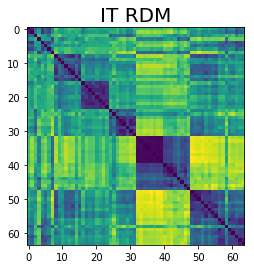

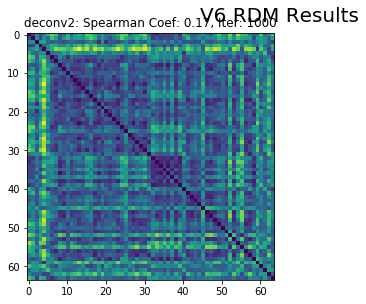

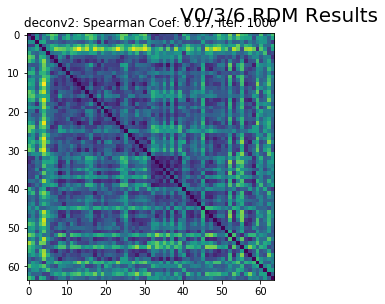

In [42]:
from math import ceil

def plot_rdms(data, target_layers, step):
    """
    Displays the RDMs of all target layers.
    
    You will need to EDIT this part. Please implement a function that visualizes 
    the rdms of all target_layers and displays the layer name as well as the 
    spearman_corrcoef in the plot title.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for i, layer in enumerate(target_layers):
        rdm = data['rdm_%s' % layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer]
        ### YOUR CODE HERE
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(rdm)
        plt.title('%s: Spearman Coef: %.2f, Iter: %s' % (layer, spearman_corrcoef, step))
        ### END OF YOUR CODE
    plt.tight_layout()


plt.title('IT RDM', fontsize=20)
plt.imshow(data_all['rdm_it'])

plot_rdms(data_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)

The RDM looks very different from the IT RDM, with a few clusters probably originating from color information.

### Analyzing the categorization results

Now let's visualize the results of the categorization test we performed for each layer. 

Your task is to plot the confusion matrix 'cms' across all categorized classes for each layer. You will need 'cms', 'labelset' and 'accbal' from data['categorization_"insert_target_layer_here"']['result_summary']. Label the x and y axis with 'labelset'. Put the layer name, average accuracy and the iteration step in the plot title. To get the average accuracy substract 0.5 from the mean of 'accbal' and multiply the result with 2. Describe what you see.

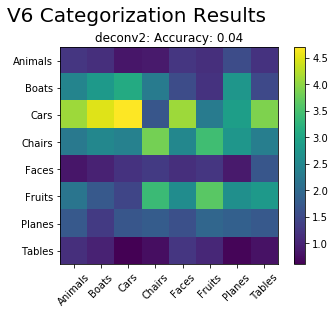

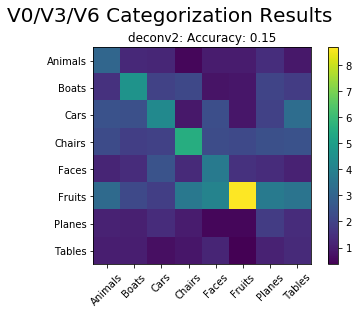

In [43]:
def plot_categorization_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    plot_size = 4
    f = plt.figure()

    for i, layer in enumerate(target_layers):
        k = 'categorization_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        confusion = np.vstack([np.mean(performance, 1) for performance in categorization_results['cms']])
        acc = (np.mean(categorization_results['accbal'])-.5)*2 # why this?
        # plot
        plt.imshow(confusion)
        plt.xticks(range(8), categorization_results['labelset'], rotation=45)
        plt.yticks(range(8), categorization_results['labelset'])
        plt.colorbar(fraction=.045)
        plt.title('%s: Accuracy: %.2f' % (layer, acc))
        ### END OF YOUR CODE
        
plot_categorization_results(data_6, target_layers, step)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_all, target_layers, step)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)


The model is quite bad, except it's kind of okay at fruits - these seemed easier for other models, too.

### Analyzing the within categorization reuslts

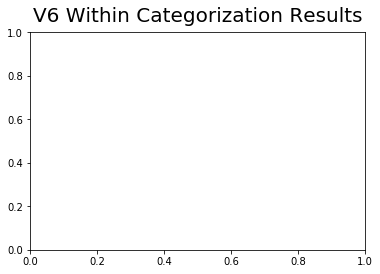

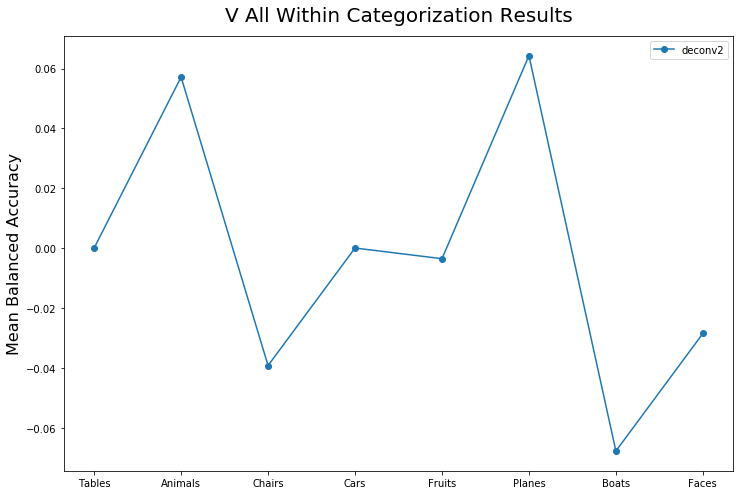

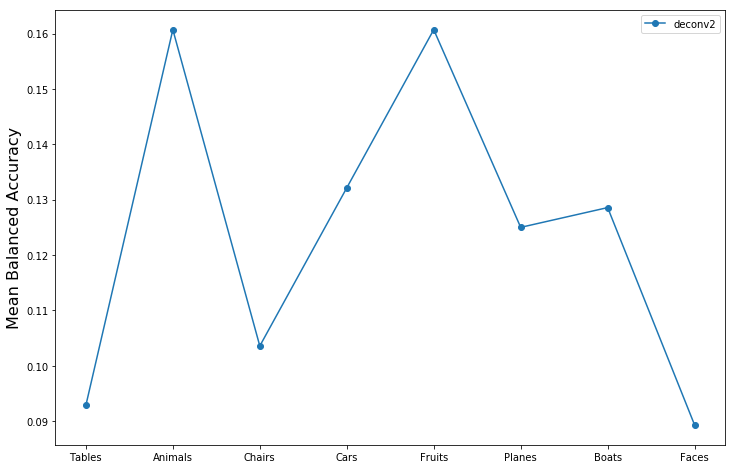

In [44]:
def plot_within_categorization_results(data, target_layers):
    plt.figure(figsize=(12,8))
    for i, layer in enumerate(target_layers):
        layer_results = data['within_categorization_%s' % layer]
        performance = [(k, (np.mean(v['result_summary']['accbal'])-.5)*2) for k,v in layer_results.items()]
        plt.plot([i[1] for i in performance], '-o', label=layer)
    plt.xticks(range(len(performance)), [i[0] for i in performance])
    plt.ylabel('Mean Balanced Accuracy', fontsize=16)
    plt.legend()
    
plt.title('V6 Within Categorization Results', fontsize=20, y=1.02)
plot_within_categorization_results(data_6, target_layers)

plt.title('V All Within Categorization Results', fontsize=20, y=1.02)
plot_within_categorization_results(data_all, target_layers)


It's very bad, because it's compressing all of the information out.

### Analyzing the regression results

We will now display the results of the regression test. 

Please print (1 - data['it\_regression_"insert_target_layer_here"']['noise_corrected_multi_rsquared_loss']) for each layer and step and label the print out with the layer name and step. Describe what you observe.

In [45]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
        
print('********** V 6 *********************')
plot_regression_results(data_6, target_layers, step)
print('\n********** V All ******************')
plot_regression_results(data_all, target_layers, step)

********** V 6 *********************
layer: deconv2, step: 1000, performance: 0.03

********** V All ******************
layer: deconv2, step: 1000, performance: 0.05


### Visualizing the conv1 kernels
Lastly, we will plot the conv1 filter kernels. 

Your task is to visualize the 'conv1_kernel' in a 12 x 8 grid. Therefore, you just have to plot each kernel as an image in a subplot. The kernels are stored in data['conv1_kernel']. Print out the iteration step and plot the kernels and describe what you see.

Iteration step: 1000


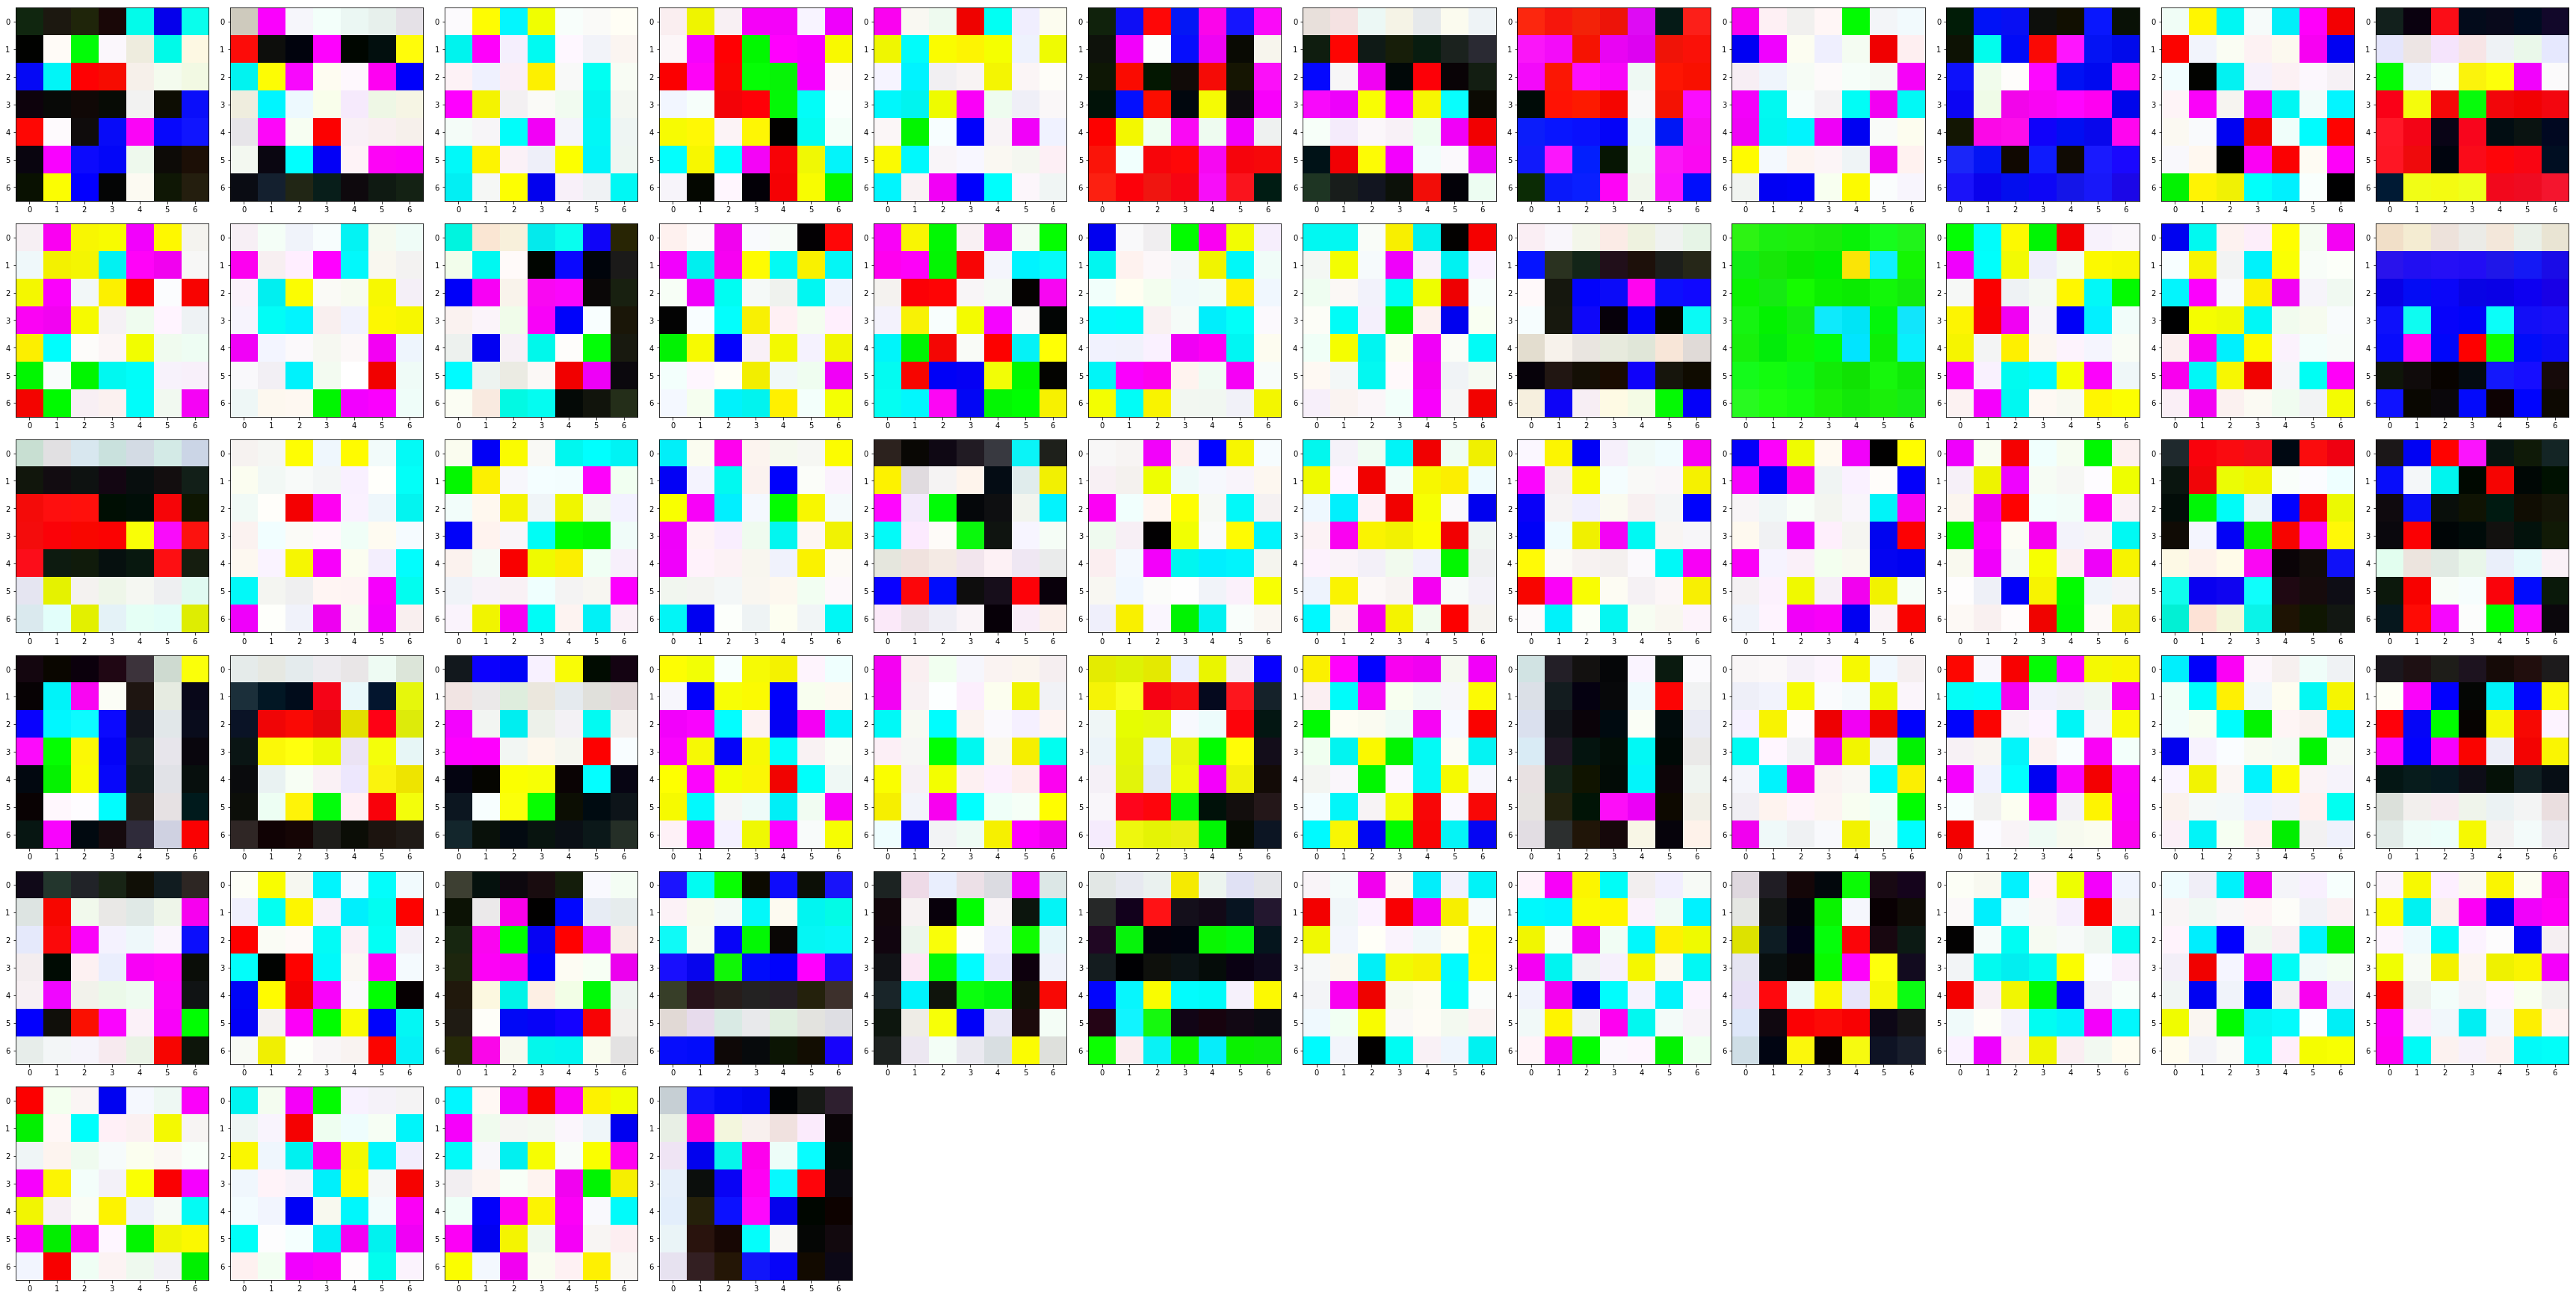

In [46]:
def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv_kernel'])
    ### YOUR CODE HERE
    xc = 0
    yc = 0
    ncols = 12
    nrows = 8
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for kernelID in range(64):
        kernel = kernels[:,:,:,kernelID]
        plt.subplot(nrows, ncols, kernelID+1)
        plt.imshow(kernel)
    plt.tight_layout()
    ### END OF YOUR CODE
           
plot_conv1_kernels(data_all, step)

The kernels appear mostly random, qualitatively.

In [48]:
def plot_imagenet_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'imagenet_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        print('{name}: avg_accuracy: {acc:.5f}; step: {step}'.format(
            name=layer,
            acc=acc,
            step=step,
        ))
        
plot_imagenet_results(data_in, target_layers, step)

deconv2: avg_accuracy: 0.03232; step: 1000


The model is also terrible on imagenet, unsurprisingly.